In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader
import os
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from collections import defaultdict
import timm
import random

In [2]:
def set_seed(seed=777):
    """Устанавливает фиксированный сид для воспроизводимости."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)           # для одного GPU
    torch.cuda.manual_seed_all(seed)       # если несколько GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(7777)

In [3]:
# Аугментация для тренировочных данных
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Только нормализация для валидации/теста
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
train_path = "/kaggle/input/cucumbers-diseases/cucumbers/train"
val_path = "/kaggle/input/cucumbers-diseases/cucumbers/test"

train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(val_path, transform=val_transform)

In [5]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
class_names = train_dataset.classes
print(f"Classes: {class_names}")
print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

Classes: ['Cucumber___Bacterial_Wilt', 'Cucumber___Downy_Mildew', 'Cucumber___Gummy_Stem_Blight', 'Cucumber___Healthy', 'Cucumber___Powdery_Mildew', 'Сucumber___Angular_leaf_spot']
Train samples: 878, Val samples: 225


In [7]:
model = timm.create_model('vit_base_patch16_224', pretrained=True)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [8]:
for param in model.parameters():
    param.requires_grad = False
    
for param in model.head.parameters():
    param.requires_grad = True
    
for param in model.blocks.parameters():
    param.requires_grad = True
    
# LayerNorm в конце
for param in model.norm.parameters():
    param.requires_grad = True

model.head = nn.Sequential(
    nn.Dropout(0.5),  # Добавляем dropout
    nn.Linear(model.head.in_features, len(class_names))
)

In [9]:
#for name, param in model.named_parameters():
    #print(name, param.requires_grad)

In [10]:
def calculate_class_accuracy(model, val_loader, num_classes):
    model.eval()
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            
            for label, pred in zip(labels, preds):
                if label == pred:
                    class_correct[label] += 1
                class_total[label] += 1
    
    for i in range(num_classes):
        print(f'Accuracy of {val_dataset.classes[i]:20s}: {100 * class_correct[i] / class_total[i]:.2f}% ({class_correct[i]}/{class_total[i]})')

In [11]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    os.makedirs('/kaggle/working/models', exist_ok=True)
    
    best_val_acc = 0.0
    best_val_loss = float('inf')
    best_epoch = 0

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}")
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping для стабильности
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            
            # Для прогресс-бара показываем текущую статистику по эпохе
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            loop.set_postfix({
                'loss': f"{running_loss / train_total:.4f}", 
                'acc': f"{100 * train_correct / train_total:.2f}%"
            })

        # Перевычисляем train accuracy в eval режиме в конце эпохи
        model.eval()
        final_train_correct = 0
        final_train_total = 0
        final_train_loss = 0.0
        
        with torch.no_grad():
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                final_train_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                final_train_total += labels.size(0)
                final_train_correct += (predicted == labels).sum().item()
        
        # Validation
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Финальные метрики
        avg_train_loss = final_train_loss / final_train_total
        avg_val_loss = val_loss / val_total
        train_acc = 100 * final_train_correct / final_train_total
        val_acc = 100 * val_correct / val_total
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Class accuracy
        calculate_class_accuracy(model, val_loader, len(class_names))
        
        # Сохранение лучшей модели (по точности)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            best_val_loss = avg_val_loss
            
            torch.save(model.state_dict(), '/kaggle/working/models/best_model.pth')
        
        model.train()
    
    # Загрузка лучшей модели в конце
    try:
        model.load_state_dict(torch.load('/kaggle/working/models/best_model.pth'))
        print(f"\nЗагружена лучшая модель с {best_epoch} эпохи")
        print(f"Лучшая Val Accuracy: {best_val_acc:.2f}%")
    except Exception as e:
        print("Ошибка при загрузке модели:", e)
        
    return model, train_losses, val_losses, train_accs, val_accs, best_epoch

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [13]:
optimizer = optim.AdamW([
    {"params": model.head.parameters(), "lr": 2e-5},
    {"params": model.norm.parameters(), "lr": 1e-5},
    {"params": model.blocks.parameters(), "lr": 3e-6}
], weight_decay=0.01)
model, train_losses, val_losses, train_accs, val_accs, best_epoch = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20)

Epoch 1/20: 100%|██████████| 28/28 [00:51<00:00,  1.85s/it, loss=2.1406, acc=16.74%]


Train Loss: 1.6326, Train Acc: 36.90%
Val Loss: 1.6821, Val Acc: 29.33%
Accuracy of Cucumber___Bacterial_Wilt: 60.00% (33/55)
Accuracy of Cucumber___Downy_Mildew: 13.33% (4/30)
Accuracy of Cucumber___Gummy_Stem_Blight: 26.67% (8/30)
Accuracy of Cucumber___Healthy  : 17.14% (6/35)
Accuracy of Cucumber___Powdery_Mildew: 0.00% (0/40)
Accuracy of Сucumber___Angular_leaf_spot: 42.86% (15/35)


Epoch 2/20: 100%|██████████| 28/28 [00:45<00:00,  1.62s/it, loss=1.6663, acc=34.62%]


Train Loss: 1.3702, Train Acc: 58.09%
Val Loss: 1.4105, Val Acc: 52.89%
Accuracy of Cucumber___Bacterial_Wilt: 87.27% (48/55)
Accuracy of Cucumber___Downy_Mildew: 66.67% (20/30)
Accuracy of Cucumber___Gummy_Stem_Blight: 36.67% (11/30)
Accuracy of Cucumber___Healthy  : 62.86% (22/35)
Accuracy of Cucumber___Powdery_Mildew: 30.00% (12/40)
Accuracy of Сucumber___Angular_leaf_spot: 17.14% (6/35)


Epoch 3/20: 100%|██████████| 28/28 [00:45<00:00,  1.62s/it, loss=1.3692, acc=51.71%]


Train Loss: 1.1289, Train Acc: 71.53%
Val Loss: 1.2057, Val Acc: 64.00%
Accuracy of Cucumber___Bacterial_Wilt: 89.09% (49/55)
Accuracy of Cucumber___Downy_Mildew: 80.00% (24/30)
Accuracy of Cucumber___Gummy_Stem_Blight: 50.00% (15/30)
Accuracy of Cucumber___Healthy  : 80.00% (28/35)
Accuracy of Cucumber___Powdery_Mildew: 35.00% (14/40)
Accuracy of Сucumber___Angular_leaf_spot: 40.00% (14/35)


Epoch 4/20: 100%|██████████| 28/28 [00:45<00:00,  1.62s/it, loss=1.1984, acc=62.41%]


Train Loss: 0.9456, Train Acc: 81.21%
Val Loss: 1.0328, Val Acc: 73.78%
Accuracy of Cucumber___Bacterial_Wilt: 87.27% (48/55)
Accuracy of Cucumber___Downy_Mildew: 80.00% (24/30)
Accuracy of Cucumber___Gummy_Stem_Blight: 56.67% (17/30)
Accuracy of Cucumber___Healthy  : 88.57% (31/35)
Accuracy of Cucumber___Powdery_Mildew: 67.50% (27/40)
Accuracy of Сucumber___Angular_leaf_spot: 54.29% (19/35)


Epoch 5/20: 100%|██████████| 28/28 [00:45<00:00,  1.62s/it, loss=0.9854, acc=74.83%]


Train Loss: 0.8049, Train Acc: 86.22%
Val Loss: 0.8851, Val Acc: 80.00%
Accuracy of Cucumber___Bacterial_Wilt: 92.73% (51/55)
Accuracy of Cucumber___Downy_Mildew: 80.00% (24/30)
Accuracy of Cucumber___Gummy_Stem_Blight: 66.67% (20/30)
Accuracy of Cucumber___Healthy  : 88.57% (31/35)
Accuracy of Cucumber___Powdery_Mildew: 75.00% (30/40)
Accuracy of Сucumber___Angular_leaf_spot: 68.57% (24/35)


Epoch 6/20: 100%|██████████| 28/28 [00:44<00:00,  1.60s/it, loss=0.8771, acc=81.21%]


Train Loss: 0.7101, Train Acc: 89.18%
Val Loss: 0.8175, Val Acc: 83.56%
Accuracy of Cucumber___Bacterial_Wilt: 90.91% (50/55)
Accuracy of Cucumber___Downy_Mildew: 80.00% (24/30)
Accuracy of Cucumber___Gummy_Stem_Blight: 63.33% (19/30)
Accuracy of Cucumber___Healthy  : 91.43% (32/35)
Accuracy of Cucumber___Powdery_Mildew: 85.00% (34/40)
Accuracy of Сucumber___Angular_leaf_spot: 82.86% (29/35)


Epoch 7/20: 100%|██████████| 28/28 [00:45<00:00,  1.61s/it, loss=0.7875, acc=85.65%]


Train Loss: 0.6696, Train Acc: 90.55%
Val Loss: 0.7525, Val Acc: 85.33%
Accuracy of Cucumber___Bacterial_Wilt: 94.55% (52/55)
Accuracy of Cucumber___Downy_Mildew: 80.00% (24/30)
Accuracy of Cucumber___Gummy_Stem_Blight: 80.00% (24/30)
Accuracy of Cucumber___Healthy  : 88.57% (31/35)
Accuracy of Cucumber___Powdery_Mildew: 87.50% (35/40)
Accuracy of Сucumber___Angular_leaf_spot: 74.29% (26/35)


Epoch 8/20: 100%|██████████| 28/28 [00:45<00:00,  1.61s/it, loss=0.7298, acc=87.36%]


Train Loss: 0.6277, Train Acc: 93.17%
Val Loss: 0.7125, Val Acc: 88.44%
Accuracy of Cucumber___Bacterial_Wilt: 90.91% (50/55)
Accuracy of Cucumber___Downy_Mildew: 86.67% (26/30)
Accuracy of Cucumber___Gummy_Stem_Blight: 80.00% (24/30)
Accuracy of Cucumber___Healthy  : 97.14% (34/35)
Accuracy of Cucumber___Powdery_Mildew: 90.00% (36/40)
Accuracy of Сucumber___Angular_leaf_spot: 82.86% (29/35)


Epoch 9/20: 100%|██████████| 28/28 [00:45<00:00,  1.63s/it, loss=0.6968, acc=89.75%]


Train Loss: 0.6013, Train Acc: 94.65%
Val Loss: 0.6751, Val Acc: 91.11%
Accuracy of Cucumber___Bacterial_Wilt: 94.55% (52/55)
Accuracy of Cucumber___Downy_Mildew: 86.67% (26/30)
Accuracy of Cucumber___Gummy_Stem_Blight: 83.33% (25/30)
Accuracy of Cucumber___Healthy  : 97.14% (34/35)
Accuracy of Cucumber___Powdery_Mildew: 95.00% (38/40)
Accuracy of Сucumber___Angular_leaf_spot: 85.71% (30/35)


Epoch 10/20: 100%|██████████| 28/28 [00:45<00:00,  1.62s/it, loss=0.6919, acc=88.95%]


Train Loss: 0.5833, Train Acc: 95.67%
Val Loss: 0.6505, Val Acc: 92.89%
Accuracy of Cucumber___Bacterial_Wilt: 96.36% (53/55)
Accuracy of Cucumber___Downy_Mildew: 86.67% (26/30)
Accuracy of Cucumber___Gummy_Stem_Blight: 83.33% (25/30)
Accuracy of Cucumber___Healthy  : 100.00% (35/35)
Accuracy of Cucumber___Powdery_Mildew: 95.00% (38/40)
Accuracy of Сucumber___Angular_leaf_spot: 91.43% (32/35)


Epoch 11/20: 100%|██████████| 28/28 [00:45<00:00,  1.61s/it, loss=0.6442, acc=92.82%]


Train Loss: 0.5650, Train Acc: 95.67%
Val Loss: 0.6270, Val Acc: 92.00%
Accuracy of Cucumber___Bacterial_Wilt: 98.18% (54/55)
Accuracy of Cucumber___Downy_Mildew: 80.00% (24/30)
Accuracy of Cucumber___Gummy_Stem_Blight: 86.67% (26/30)
Accuracy of Cucumber___Healthy  : 94.29% (33/35)
Accuracy of Cucumber___Powdery_Mildew: 92.50% (37/40)
Accuracy of Сucumber___Angular_leaf_spot: 94.29% (33/35)


Epoch 12/20: 100%|██████████| 28/28 [00:45<00:00,  1.62s/it, loss=0.6206, acc=93.74%]


Train Loss: 0.5470, Train Acc: 96.81%
Val Loss: 0.6072, Val Acc: 92.89%
Accuracy of Cucumber___Bacterial_Wilt: 96.36% (53/55)
Accuracy of Cucumber___Downy_Mildew: 80.00% (24/30)
Accuracy of Cucumber___Gummy_Stem_Blight: 86.67% (26/30)
Accuracy of Cucumber___Healthy  : 97.14% (34/35)
Accuracy of Cucumber___Powdery_Mildew: 100.00% (40/40)
Accuracy of Сucumber___Angular_leaf_spot: 91.43% (32/35)


Epoch 13/20: 100%|██████████| 28/28 [00:45<00:00,  1.62s/it, loss=0.5936, acc=94.08%]


Train Loss: 0.5384, Train Acc: 96.58%
Val Loss: 0.6034, Val Acc: 93.78%
Accuracy of Cucumber___Bacterial_Wilt: 92.73% (51/55)
Accuracy of Cucumber___Downy_Mildew: 90.00% (27/30)
Accuracy of Cucumber___Gummy_Stem_Blight: 86.67% (26/30)
Accuracy of Cucumber___Healthy  : 100.00% (35/35)
Accuracy of Cucumber___Powdery_Mildew: 100.00% (40/40)
Accuracy of Сucumber___Angular_leaf_spot: 91.43% (32/35)


Epoch 14/20: 100%|██████████| 28/28 [00:45<00:00,  1.62s/it, loss=0.5756, acc=96.13%]


Train Loss: 0.5216, Train Acc: 97.84%
Val Loss: 0.5826, Val Acc: 94.22%
Accuracy of Cucumber___Bacterial_Wilt: 92.73% (51/55)
Accuracy of Cucumber___Downy_Mildew: 93.33% (28/30)
Accuracy of Cucumber___Gummy_Stem_Blight: 86.67% (26/30)
Accuracy of Cucumber___Healthy  : 100.00% (35/35)
Accuracy of Cucumber___Powdery_Mildew: 100.00% (40/40)
Accuracy of Сucumber___Angular_leaf_spot: 91.43% (32/35)


Epoch 15/20: 100%|██████████| 28/28 [00:45<00:00,  1.61s/it, loss=0.5635, acc=96.36%]


Train Loss: 0.5060, Train Acc: 97.95%
Val Loss: 0.5720, Val Acc: 95.56%
Accuracy of Cucumber___Bacterial_Wilt: 94.55% (52/55)
Accuracy of Cucumber___Downy_Mildew: 90.00% (27/30)
Accuracy of Cucumber___Gummy_Stem_Blight: 90.00% (27/30)
Accuracy of Cucumber___Healthy  : 100.00% (35/35)
Accuracy of Cucumber___Powdery_Mildew: 100.00% (40/40)
Accuracy of Сucumber___Angular_leaf_spot: 97.14% (34/35)


Epoch 16/20: 100%|██████████| 28/28 [00:44<00:00,  1.57s/it, loss=0.5424, acc=96.81%]


Train Loss: 0.5069, Train Acc: 97.61%
Val Loss: 0.5683, Val Acc: 94.22%
Accuracy of Cucumber___Bacterial_Wilt: 98.18% (54/55)
Accuracy of Cucumber___Downy_Mildew: 83.33% (25/30)
Accuracy of Cucumber___Gummy_Stem_Blight: 83.33% (25/30)
Accuracy of Cucumber___Healthy  : 100.00% (35/35)
Accuracy of Cucumber___Powdery_Mildew: 100.00% (40/40)
Accuracy of Сucumber___Angular_leaf_spot: 94.29% (33/35)


Epoch 17/20: 100%|██████████| 28/28 [00:43<00:00,  1.55s/it, loss=0.5393, acc=96.70%]


Train Loss: 0.4974, Train Acc: 98.52%
Val Loss: 0.5536, Val Acc: 94.67%
Accuracy of Cucumber___Bacterial_Wilt: 96.36% (53/55)
Accuracy of Cucumber___Downy_Mildew: 90.00% (27/30)
Accuracy of Cucumber___Gummy_Stem_Blight: 86.67% (26/30)
Accuracy of Cucumber___Healthy  : 100.00% (35/35)
Accuracy of Cucumber___Powdery_Mildew: 100.00% (40/40)
Accuracy of Сucumber___Angular_leaf_spot: 91.43% (32/35)


Epoch 18/20: 100%|██████████| 28/28 [00:43<00:00,  1.55s/it, loss=0.5308, acc=97.15%]


Train Loss: 0.4905, Train Acc: 98.75%
Val Loss: 0.5399, Val Acc: 97.78%
Accuracy of Cucumber___Bacterial_Wilt: 100.00% (55/55)
Accuracy of Cucumber___Downy_Mildew: 100.00% (30/30)
Accuracy of Cucumber___Gummy_Stem_Blight: 93.33% (28/30)
Accuracy of Cucumber___Healthy  : 97.14% (34/35)
Accuracy of Cucumber___Powdery_Mildew: 100.00% (40/40)
Accuracy of Сucumber___Angular_leaf_spot: 94.29% (33/35)


Epoch 19/20: 100%|██████████| 28/28 [00:43<00:00,  1.56s/it, loss=0.5151, acc=98.41%]


Train Loss: 0.4785, Train Acc: 99.09%
Val Loss: 0.5422, Val Acc: 95.11%
Accuracy of Cucumber___Bacterial_Wilt: 94.55% (52/55)
Accuracy of Cucumber___Downy_Mildew: 90.00% (27/30)
Accuracy of Cucumber___Gummy_Stem_Blight: 90.00% (27/30)
Accuracy of Cucumber___Healthy  : 100.00% (35/35)
Accuracy of Cucumber___Powdery_Mildew: 100.00% (40/40)
Accuracy of Сucumber___Angular_leaf_spot: 94.29% (33/35)


Epoch 20/20: 100%|██████████| 28/28 [00:43<00:00,  1.56s/it, loss=0.5062, acc=98.52%]


Train Loss: 0.4703, Train Acc: 98.97%
Val Loss: 0.5321, Val Acc: 95.56%
Accuracy of Cucumber___Bacterial_Wilt: 94.55% (52/55)
Accuracy of Cucumber___Downy_Mildew: 90.00% (27/30)
Accuracy of Cucumber___Gummy_Stem_Blight: 93.33% (28/30)
Accuracy of Cucumber___Healthy  : 100.00% (35/35)
Accuracy of Cucumber___Powdery_Mildew: 100.00% (40/40)
Accuracy of Сucumber___Angular_leaf_spot: 94.29% (33/35)

Загружена лучшая модель с 18 эпохи
Лучшая Val Accuracy: 97.78%


In [14]:
def plot_loss_acc(train_losses, val_losses, train_accs, val_accs, best_epoch):
    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 8))
    
    # График лоссов
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.axvline(x=best_epoch, color='red', linestyle='--', linewidth=1, label=f'Best epoch ({best_epoch})')  # <<< Линия
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # График accuracy
    plt.subplot(2, 1, 2)
    plt.plot(epochs_range, train_accs, label='Train Accuracy')
    plt.plot(epochs_range, val_accs, label='Val Accuracy')
    plt.axvline(x=best_epoch, color='red', linestyle='--', linewidth=1, label=f'Best epoch ({best_epoch})')  # <<< Линия
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/training_metrics.png')
    plt.show()

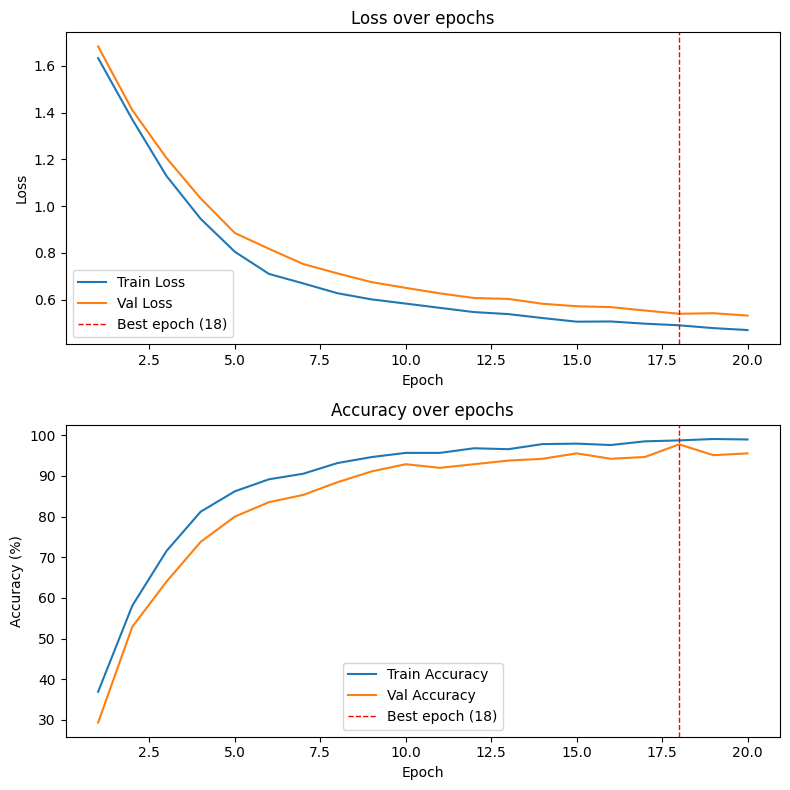

In [15]:
plot_loss_acc(train_losses, val_losses, train_accs, val_accs, best_epoch)

In [16]:
# Вспомогательная функция
def evaluate_confusion(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_labels, all_preds

# Получаем предсказания для валидационного набора
true_labels, pred_labels = evaluate_confusion(model, val_loader, class_names)

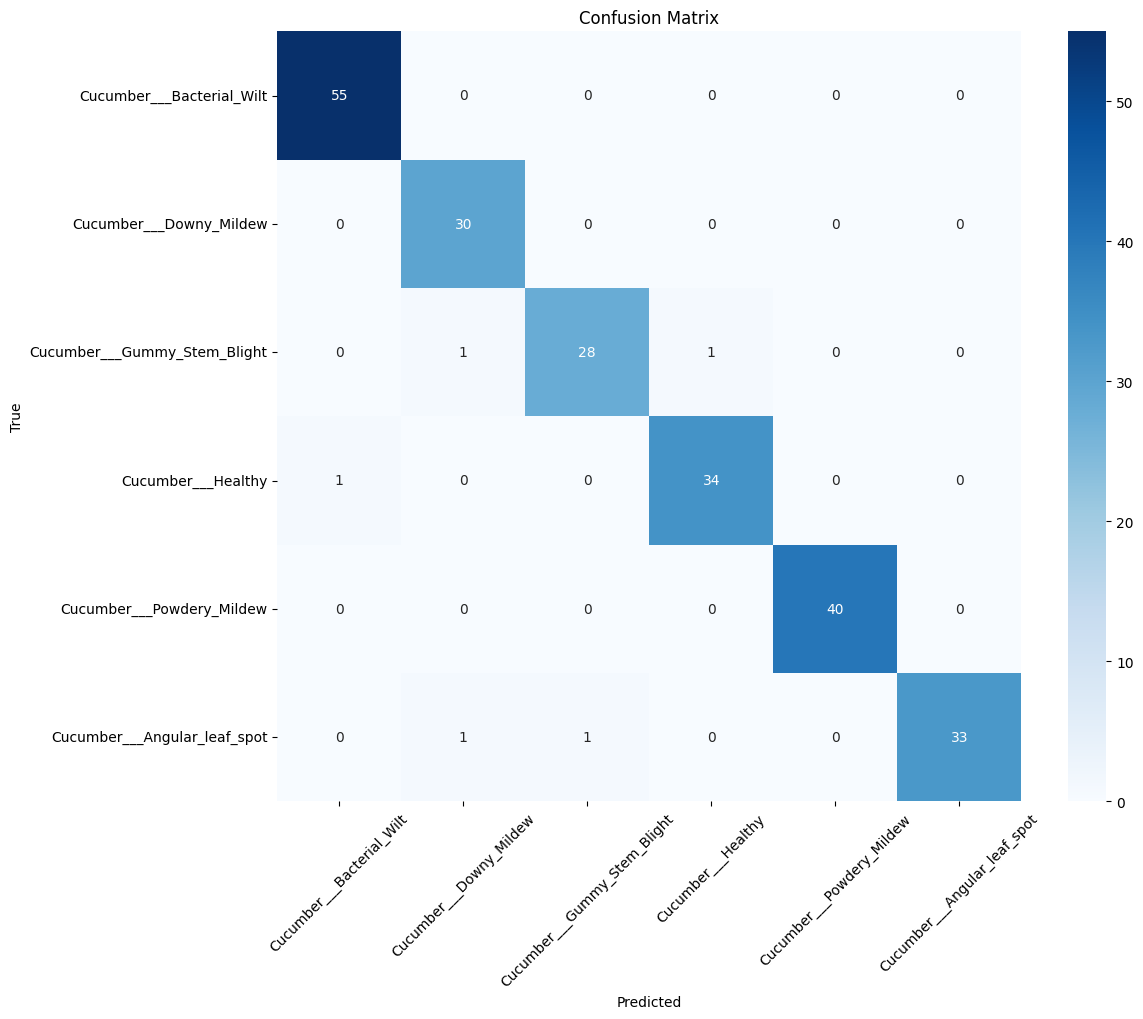

In [17]:
# Матрица ошибок
def plot_confusion_matrix(true_labels, pred_labels, class_names):
    cm = confusion_matrix(true_labels, pred_labels)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', 
                xticklabels=class_names, 
                yticklabels=class_names,
                cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

plot_confusion_matrix(true_labels, pred_labels, class_names)

In [18]:
# Топ ошибок
def find_top_confusions(cm, class_names, top_n=5):
    confusions = defaultdict(int)
    
    for i in range(len(cm)):
        for j in range(len(cm)):
            if i != j and cm[i][j] > 0:
                pair = (class_names[i], class_names[j])
                confusions[pair] += cm[i][j]
    
    # Сортируем по количеству ошибок
    sorted_confs = sorted(confusions.items(), key=lambda x: x[1], reverse=True)
    
    print("\nТоп ошибок:")
    for (true, pred), count in sorted_confs[:top_n]:
        print(f"{true} → {pred}: {count} случая")

find_top_confusions(confusion_matrix(true_labels, pred_labels), class_names)


Топ ошибок:
Cucumber___Gummy_Stem_Blight → Cucumber___Downy_Mildew: 1 случая
Cucumber___Gummy_Stem_Blight → Cucumber___Healthy: 1 случая
Cucumber___Healthy → Cucumber___Bacterial_Wilt: 1 случая
Сucumber___Angular_leaf_spot → Cucumber___Downy_Mildew: 1 случая
Сucumber___Angular_leaf_spot → Cucumber___Gummy_Stem_Blight: 1 случая
